# Analysing the Spotify Charts
Every week, Spotify releases the top 200 charts, showing the most listened to songs over the last 7 days on a global and per-country (market) basis. For this project, I have chosen to take the Weekly Top Songs chart from the week of October 7th - 13th 2022, and compare the global and UK-only versions. To enrich this data, I have used the Spotify API to retrieve details about each charted song. Let's get started.

## Glossary 
* track - A song or other audio file in Spotify's catalog

## Initial setup

In [1]:
import pandas as pd
import spotipy
import seaborn as sns
from spotipy.oauth2 import SpotifyClientCredentials

# Acquiring charts data
Conveniently, Spotify makes the charts data available as a CSV file [here](https://charts.spotify.com/charts/view/regional-global-weekly).

I've downloaded the two relevant files:
data/charts/2022_10_13_global.csv
data/charts/2022_10_13_gb.csv

Let's load up those files.

In [2]:
globalCharts = pd.read_csv("./data/charts/2022_10_13_global.csv")
gbCharts = pd.read_csv("./data/charts/2022_10_13_gb.csv")

Now we have the data loaded, let's have a bit of an explore.

In [3]:
globalCharts.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams
0,1,spotify:track:3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),EMI,1,1,3,50678989
1,2,spotify:track:4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",I'm Good (Blue),Parlophone UK,2,2,7,33390068
2,3,spotify:track:4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Columbia,1,3,28,31732480
3,4,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,"Bizarrap, Quevedo","Quevedo: Bzrp Music Sessions, Vol. 52",DALE PLAY Records,1,4,14,30122972
4,5,spotify:track:5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,Sony Music Latin/La Industria,5,5,15,29422694


In [4]:
list(globalCharts.columns)


['rank',
 'uri',
 'artist_names',
 'track_name',
 'source',
 'peak_rank',
 'previous_rank',
 'weeks_on_chart',
 'streams']

Here, we see that each record is a entry on this week's chart, with the following attributes: 

* uri - Spotify's Unique Reference Indicator for the track
* artist_names - A concatenated string of the artists involved in the track
* track_name - The track's name
* peak_rank - The "best" (lowest) position that this song has ever achieved on this chart 
* previous_rank - The rank of the track last week, used for calculating differences over time
* weeks_on_chart - The number of continuous weeks that this track has spent in the charts
* streams - The total number of times this track has been streamed in the past week in the relevant region

Now, let's define some questions: 
* What is the "most average" track in the global charts?
* How did dance tracks perform in this week?
* What kind of tracks charted in the UK but not globally?

To answer any of these questions, we need to know more info about what each track is like. Luckily, Spotify uses algorithms to give each song a variety of attributes that are designed to tell you quantitatively what a song is like, and makes these available via its API. Let's download the details about each song in our dataset

# Getting song attributes 
First, we need to set up Spotipy, which will be our interface with the API. Then, let's test that it works using Taylor Swift's *Better Than Revenge* as a demo.

In [5]:
SPOTIPY_CLIENT_ID = "c87d94fc86754ae4bb478a50402a3254"
SPOTIPY_CLIENT_SECRET = "1739de3f5fe14e74b8e6c61eb1c9069c"

auth_manager = SpotifyClientCredentials(client_id= SPOTIPY_CLIENT_ID, client_secret=SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [6]:
revenge = sp.audio_features("0PWgAyoxsjwGRuFSO0fyya")[0]
revenge

{'danceability': 0.519,
 'energy': 0.917,
 'key': 11,
 'loudness': -3.185,
 'mode': 0,
 'speechiness': 0.0887,
 'acousticness': 0.0167,
 'instrumentalness': 2.06e-05,
 'liveness': 0.359,
 'valence': 0.652,
 'tempo': 145.882,
 'type': 'audio_features',
 'id': '0PWgAyoxsjwGRuFSO0fyya',
 'uri': 'spotify:track:0PWgAyoxsjwGRuFSO0fyya',
 'track_href': 'https://api.spotify.com/v1/tracks/0PWgAyoxsjwGRuFSO0fyya',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0PWgAyoxsjwGRuFSO0fyya',
 'duration_ms': 217173,
 'time_signature': 4}

Here, we see that lots of attributes have been assigned to the track. The ones that I think are most interesting are: 

* duration_ms - length of track in milliseconds
* danceability
* energy
* loudness
* instrumentalness - How much of the track is instrumental
* speechyness - How much speech is in the track
* tempo - bpm

Now we know what we're interested in, let's run this over the entirity of both globalCharts and gbCharts.

In [7]:
for i, row in globalCharts.iterrows():
    uri = row['uri']
    res = sp.audio_features(uri)[0]
    globalCharts.loc[i, "duration_ms"] = res["duration_ms"]
    globalCharts.loc[i, "danceability"] = res["danceability"]
    globalCharts.loc[i, "energy"] = res["energy"]
    globalCharts.loc[i, "loudness"] = res["loudness"]
    globalCharts.loc[i, "instrumentalness"] = res["instrumentalness"]
    globalCharts.loc[i, "speechiness"] = res["speechiness"]
    globalCharts.loc[i, "tempo"] = res["tempo"]    
    
for i, row in gbCharts.iterrows():
    uri = row['uri']
    res = sp.audio_features(uri)[0]
    gbCharts.loc[i, "duration_ms"] = res["duration_ms"]
    gbCharts.loc[i, "danceability"] = res["danceability"]
    gbCharts.loc[i, "energy"] = res["energy"]
    gbCharts.loc[i, "loudness"] = res["loudness"]
    gbCharts.loc[i, "instrumentalness"] = res["instrumentalness"]
    gbCharts.loc[i, "speechiness"] = res["speechiness"]
    gbCharts.loc[i, "tempo"] = res["tempo"]    
    
print("Complete")

Complete


In [8]:
globalCharts.to_csv("./data/charts/output/globalCharts.csv")
gbCharts.to_csv("./data/charts/output/gbCharts.csv")

In [9]:
globalCharts.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,duration_ms,danceability,energy,loudness,instrumentalness,speechiness,tempo
0,1,spotify:track:3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),EMI,1,1,3,50678989,156943.0,0.714,0.472,-7.375,0.000005,0.0864,131.121
1,2,spotify:track:4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",I'm Good (Blue),Parlophone UK,2,2,7,33390068,175238.0,0.561,0.965,-3.673,0.000007,0.0343,128.040
2,3,spotify:track:4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Columbia,1,3,28,31732480,167303.0,0.520,0.731,-5.338,0.001010,0.0557,173.930
3,4,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,"Bizarrap, Quevedo","Quevedo: Bzrp Music Sessions, Vol. 52",DALE PLAY Records,1,4,14,30122972,198938.0,0.621,0.782,-5.548,0.033000,0.0440,128.033
4,5,spotify:track:5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,Sony Music Latin/La Industria,5,5,15,29422694,162638.0,0.835,0.679,-5.329,0.000002,0.0364,124.980


Now we have a dataframe combining all of these traits, let's start answering questions.

## Cleaning the data
There isn't any cleaning that needs to be done as such to the data, as it is complete and standardised in a usable format, but there are some places where we can modify the data slighly to improve usability, such as:

* Convert duration from milliseconds to seconds
* Work out the change in rank between last week and this week

I'm also from the world of R, where tidy data rules supreme, so let's also create tidy dataframe versions of both charts, and a combined version for future analyis.

In [10]:
# ms to s
globalCharts["duration_s"] = globalCharts["duration_ms"] / 1000
gbCharts["duration_s"] = gbCharts["duration_ms"] / 1000

# changed rank
globalCharts["change_rank"] = globalCharts["previous_rank"] - globalCharts["rank"]
gbCharts["change_rank"] = gbCharts["previous_rank"] - gbCharts["rank"]

# add region data
globalCharts["region"] = "Global"
gbCharts["region"] = "UK"

# make tidy versions
tidyGlobalCharts = pd.melt(globalCharts,id_vars=["uri", "artist_names", "track_name", "region"], value_vars=["rank", "peak_rank","previous_rank","weeks_on_chart","streams","duration_ms","danceability","energy","loudness","instrumentalness","speechiness","tempo"])
tidyGbCharts = pd.melt(gbCharts,id_vars=["uri", "artist_names", "track_name","region"], value_vars=["rank","peak_rank","previous_rank","weeks_on_chart","streams","duration_ms","danceability","energy","loudness","instrumentalness","speechiness","tempo"])

# make a combined tidy version
tidy = pd.concat([tidyGlobalCharts, tidyGbCharts])
tidyGlobalCharts.head()

,uri,artist_names,track_name,region,variable,value
0,spotify:track:3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),Global,rank,1.0
1,spotify:track:4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",I'm Good (Blue),Global,rank,2.0
2,spotify:track:4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Global,rank,3.0
3,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,"Bizarrap, Quevedo","Quevedo: Bzrp Music Sessions, Vol. 52",Global,rank,4.0
4,spotify:track:5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,Global,rank,5.0


In [11]:
globalCharts.head()

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,duration_ms,danceability,energy,loudness,instrumentalness,speechiness,tempo,duration_s,change_rank,region
0,1,spotify:track:3nqQXoyQOWXiESFLlDF1hG,"Sam Smith, Kim Petras",Unholy (feat. Kim Petras),EMI,1,1,3,50678989,156943.0,0.714,0.472,-7.375,0.000005,0.0864,131.121,156.943,0,Global
1,2,spotify:track:4uUG5RXrOk84mYEfFvj3cK,"David Guetta, Bebe Rexha",I'm Good (Blue),Parlophone UK,2,2,7,33390068,175238.0,0.561,0.965,-3.673,0.000007,0.0343,128.040,175.238,0,Global
2,3,spotify:track:4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,Columbia,1,3,28,31732480,167303.0,0.520,0.731,-5.338,0.001010,0.0557,173.930,167.303,0,Global
3,4,spotify:track:2tTmW7RDtMQtBk7m2rYeSw,"Bizarrap, Quevedo","Quevedo: Bzrp Music Sessions, Vol. 52",DALE PLAY Records,1,4,14,30122972,198938.0,0.621,0.782,-5.548,0.033000,0.0440,128.033,198.938,0,Global
4,5,spotify:track:5ww2BF9slyYgNOk37BlC4u,Manuel Turizo,La Bachata,Sony Music Latin/La Industria,5,5,15,29422694,162638.0,0.835,0.679,-5.329,0.000002,0.0364,124.980,162.638,0,Global


## Exploring the data
Now we have all the data that we want, let's explore it. First, calculating measures of location and spread:

In [12]:
globalCharts.describe()

,rank,peak_rank,previous_rank,weeks_on_chart,streams,duration_ms,danceability,energy,loudness,instrumentalness,speechiness,tempo,duration_s,change_rank
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,44.825000,93.090000,43.460000,1.009087e+07,207804.135000,0.663470,0.664195,-5.97732,0.017286,0.086666,122.309570,207.804135,-7.410000
std,57.879185,46.459085,58.517977,53.658968,5.808976e+06,44703.414064,0.148551,0.158423,2.47997,0.079885,0.083672,29.144891,44.703414,29.642966
min,1.000000,1.000000,-1.000000,1.000000,5.889409e+06,97393.000000,0.323000,0.192000,-16.16900,0.000000,0.023200,67.528000,97.393000,-201.000000
25%,50.750000,5.000000,42.750000,9.000000,6.869498e+06,176868.750000,0.567500,0.563250,-7.24550,0.000000,0.037475,100.022750,176.868750,-6.000000
50%,100.500000,25.500000,92.500000,23.000000,8.002894e+06,205545.000000,0.678000,0.687500,-5.49400,0.000003,0.053000,118.071000,205.545000,-1.000000
75%,150.250000,77.250000,142.250000,61.250000,1.046357e+07,234330.000000,0.781750,0.779250,-4.44875,0.000091,0.089325,140.025750,234.330000,3.000000
max,200.000000,181.000000,200.000000,297.000000,5.067899e+07,354520.000000,0.951000,0.972000,-0.51400,0.631000,0.448000,202.466000,354.520000,51.000000


There are lots of columns, so here are my most interesting observations:

* Songs tend to be around 210 seconds (3.5 minutes) long, with a pretty small amount of variation around that (standard deviation = 40 seconds)
* Songs have on average been in the charts for 43 weeks, which is impressive. The longest song has been there for 297 weeks (nearly 6 years!)
* The median instrumentalness is 0.000003 but the mean is 0.017286 - a pretty impressive difference. This is likely because most songs aren't very instrumental, but a few are nearly all instrumental. This is reflected in the 25/75th percentiles

Now, let's plot some charts.

In [13]:
sns.set_theme(style="darkgrid")

<AxesSubplot: xlabel='value', ylabel='Count'>

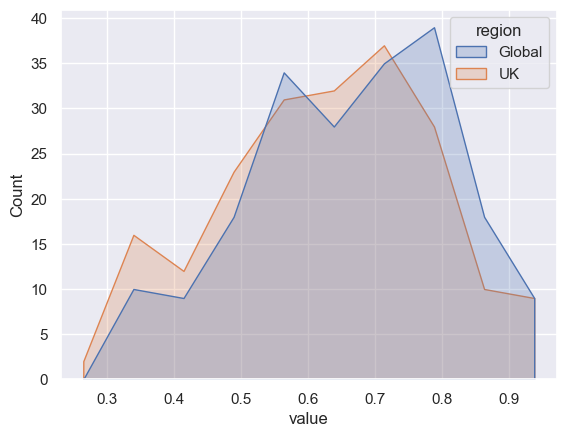

In [14]:
sns.histplot(data=tidy[tidy["variable"] == "danceability"], hue="region",element="poly", x="value", bins=10)

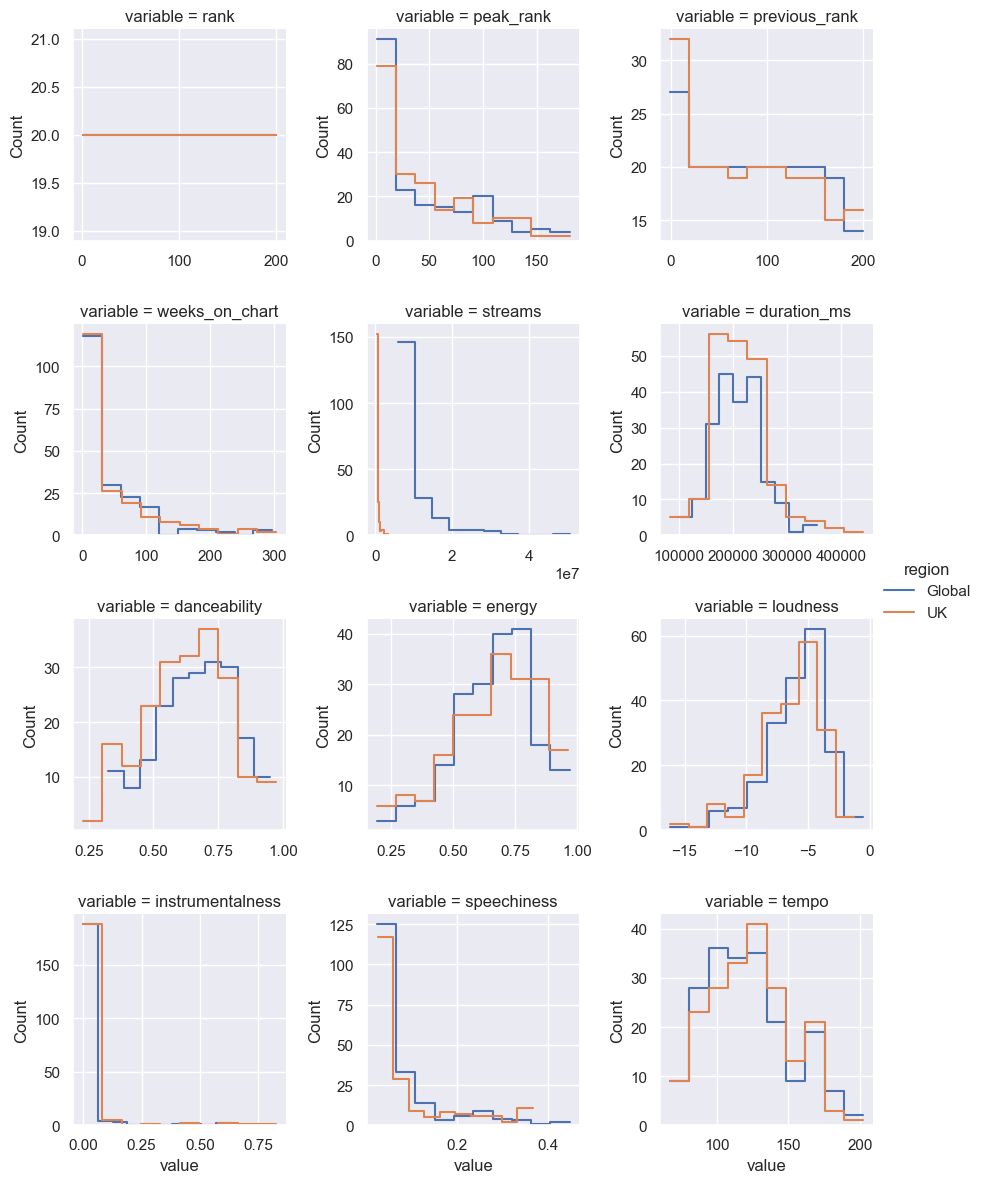

In [15]:
grid = sns.FacetGrid(tidy, col="variable", hue="region", col_wrap=3, sharey=False, sharex=False)
grid.map(sns.histplot, "value", element="step", bins=10, fill=False, common_bins=True)
grid.add_legend()

Now we have a histogram for each numeric variable, here are my interesting findings: 

* Tracks tend to spend slightly longer in the UK charts than the Global charts
* UK tracks tend to be less dancable than global ones
* Global tracks tend to contan less speech
* There is less variation in the length of UK tracks than global ones
* Global tracks are more likely to have once been in the top 20 than UK ones

These are all interesting findings, so let's move onto our questions.

## What is the most average track in the global charts?
There are in essence two parts to this question:

* What is the average (in this case median, as it generally avoids outlier effects) of each variable
* Which track is the closest fit to those values

For the first part, let's find the median of each variable.

In [16]:
# # filter for only global
ma = tidy[tidy["region"] == "Global"]
maw = pd.pivot(ma, index = ["uri", "track_name", "artist_names"],columns="variable", values="value")
maw.reset_index()
maw
# maw.drop("variable")
# maw.head()
avg = maw.median(axis=0)

Lovely, we now have median values.

In order to assess what is closest to the median, my proposed method is: 

* Normalise all variables from 0 to 1 using min-max
* Calculate the median of each normalized variable
* Calculate the absolute difference between each track's value and the median for each variable
* Calculate the sum of the differences
* Sort by lowest difference score

In [17]:
# normalise using min/max
mawn=(maw-maw.min())/(maw.max()-maw.min())
mawn

,,variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
uri,track_name,artist_names,,,,,,,,,,,,
spotify:track:003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,0.046178,0.488397,0.921795,0.000000,0.698754,0.538889,0.985075,0.974874,0.121234,0.002255,0.596607,0.388514
spotify:track:02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,0.697452,0.549969,0.426923,0.000011,0.592079,0.000000,0.114428,0.105528,0.167608,0.216465,0.098875,0.314189
spotify:track:086myS9r57YsLbJpU0TgK9,Why'd You Only Call Me When You're High?,Arctic Monkeys,0.585987,0.247858,0.562821,0.000018,0.619035,0.572222,0.631841,0.613065,0.032015,0.031633,0.181387,0.162162
spotify:track:09mEdoA6zrmBPgTEN5qXmN,Call Out My Name,The Weeknd,0.219745,0.509398,0.514103,0.000000,0.716385,0.000000,0.383085,0.376884,0.029190,0.070629,0.493871,0.168919
spotify:track:0B7wvvmu9EISAwZnOpjhNI,When I Was Your Man,Bruno Mars,0.442675,0.452827,0.101282,0.000000,0.477866,1.000000,0.930348,0.909548,0.040254,0.007394,0.577791,0.020270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:7qiZfU4dY1lWllzX7mPBI3,Shape of You,Ed Sheeran,0.799363,0.530166,0.589744,0.000000,0.829511,0.000000,0.945274,0.954774,0.134181,0.003156,0.210830,0.996622
spotify:track:7sJNeWTXkZCEC7OnFMpGWL,Bamba (feat. Aitch & BIA),"Luciano, Aitch, BIA",0.754777,0.412897,0.767949,0.000000,0.631619,0.388889,0.402985,0.587940,0.722222,0.033996,0.522447,0.006757
spotify:track:7wdwIaXUuzlu1grzWMFRJm,Mary On A Cross,Ghost,0.229299,0.573300,0.907692,0.000781,0.745065,0.194444,0.248756,0.271357,0.051554,0.098304,0.463168,0.027027


In [18]:
# calculate median of normalised
navg = mawn.median(axis=0)
navg

variable
danceability        0.565287
duration_ms         0.420617
energy              0.635256
instrumentalness    0.000005
loudness            0.681891
peak_rank           0.136111
previous_rank       0.465174
rank                0.500000
speechiness         0.070151
streams             0.047187
tempo               0.374565
weeks_on_chart      0.074324
dtype: float64

In [19]:
# calculate abs difference
mawnd = abs(mawn-navg)
mawnd.reset_index()
mawnd

,,variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
uri,track_name,artist_names,,,,,,,,,,,,
spotify:track:003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,0.519108,0.067780,0.286538,0.000005,0.016864,0.402778,0.519900,0.474874,0.051083,0.044932,0.222043,0.314189
spotify:track:02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,0.132166,0.129352,0.208333,0.000006,0.089812,0.136111,0.350746,0.394472,0.097458,0.169278,0.275690,0.239865
spotify:track:086myS9r57YsLbJpU0TgK9,Why'd You Only Call Me When You're High?,Arctic Monkeys,0.020701,0.172759,0.072436,0.000013,0.062855,0.436111,0.166667,0.113065,0.038136,0.015554,0.193178,0.087838
spotify:track:09mEdoA6zrmBPgTEN5qXmN,Call Out My Name,The Weeknd,0.345541,0.088781,0.121154,0.000005,0.034494,0.136111,0.082090,0.123116,0.040960,0.023442,0.119307,0.094595
spotify:track:0B7wvvmu9EISAwZnOpjhNI,When I Was Your Man,Bruno Mars,0.122611,0.032210,0.533974,0.000005,0.204024,0.863889,0.465174,0.409548,0.029896,0.039793,0.203227,0.054054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
spotify:track:7qiZfU4dY1lWllzX7mPBI3,Shape of You,Ed Sheeran,0.234076,0.109549,0.045513,0.000005,0.147621,0.136111,0.480100,0.454774,0.064030,0.044031,0.163734,0.922297
spotify:track:7sJNeWTXkZCEC7OnFMpGWL,Bamba (feat. Aitch & BIA),"Luciano, Aitch, BIA",0.189490,0.007720,0.132692,0.000005,0.050271,0.252778,0.062189,0.087940,0.652072,0.013191,0.147883,0.067568
spotify:track:7wdwIaXUuzlu1grzWMFRJm,Mary On A Cross,Ghost,0.335987,0.152683,0.272436,0.000776,0.063175,0.058333,0.216418,0.228643,0.018597,0.051117,0.088604,0.047297


In [20]:
# calculate sum of differences
mawnds = mawnd.sum(axis=1).to_frame()

In [21]:
# sort ascending
mawndsds= mawnds.sort_values(by=[0])

In [22]:
mawndsds.head()

,,,0
uri,track_name,artist_names,
spotify:track:5uSFGgIfHMT3osrAd9n9ym,Forget Me,Lewis Capaldi,0.637952
spotify:track:5QO79kh1waicV47BqGRL3g,Save Your Tears,The Weeknd,0.803134
spotify:track:2DB4DdfCFMw1iaR6JaR03a,Bam Bam (feat. Ed Sheeran),"Camila Cabello, Ed Sheeran",0.815953
spotify:track:5Z9KJZvQzH6PFmb8SNkxuk,INDUSTRY BABY (feat. Jack Harlow),"Lil Nas X, Jack Harlow",0.872000
spotify:track:5TJEBoTCDbJXiKMdCN9pd3,Hold Me Closer,"Elton John, Britney Spears",0.889735


In [23]:
globalCharts[globalCharts["track_name"] == "Forget Me"]

,rank,uri,artist_names,track_name,source,peak_rank,previous_rank,weeks_on_chart,streams,duration_ms,danceability,energy,loudness,instrumentalness,speechiness,tempo,duration_s,change_rank,region
104,105,spotify:track:5uSFGgIfHMT3osrAd9n9ym,Lewis Capaldi,Forget Me,Vertigo Berlin,57,96,5,7848814,203472.0,0.669,0.742,-3.518,0.0,0.0441,101.982,203.472,-9,Global


So, the most "average" track in the global charts is 'Forget Me' by Lewis Capaldi. It's a reasonably dancable, high energy song of length 3:23, that is slowly fading from the charts in this particular week.

## How did dance tracks perform this week?
I think the place to start here is to plot danceability against rank for both charts.

In [24]:
dar = pd.pivot(ma, index = ["uri", "track_name", "artist_names", "region"],columns="variable", values="value")
dar.head()

,,,variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
uri,track_name,artist_names,region,,,,,,,,,,,,
spotify:track:003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers,Global,0.352,222973.0,0.911,0.000000,-5.230,98.0,197.0,195.0,0.0747,5990388.0,148.033,116.0
spotify:track:02MWAaffLxlfxAUY7c5dvx,Heat Waves,Glass Animals,Global,0.761,238805.0,0.525,0.000007,-6.900,1.0,22.0,22.0,0.0944,15584788.0,80.870,94.0
spotify:track:086myS9r57YsLbJpU0TgK9,Why'd You Only Call Me When You're High?,Arctic Monkeys,Global,0.691,161124.0,0.631,0.000011,-6.478,104.0,126.0,123.0,0.0368,7306223.0,92.004,49.0
spotify:track:09mEdoA6zrmBPgTEN5qXmN,Call Out My Name,The Weeknd,Global,0.461,228373.0,0.593,0.000000,-4.954,1.0,76.0,76.0,0.0356,9052839.0,134.170,51.0
spotify:track:0B7wvvmu9EISAwZnOpjhNI,When I Was Your Man,Bruno Mars,Global,0.601,213827.0,0.271,0.000000,-8.688,181.0,186.0,182.0,0.0403,6220603.0,145.494,7.0


<AxesSubplot: xlabel='danceability', ylabel='rank'>

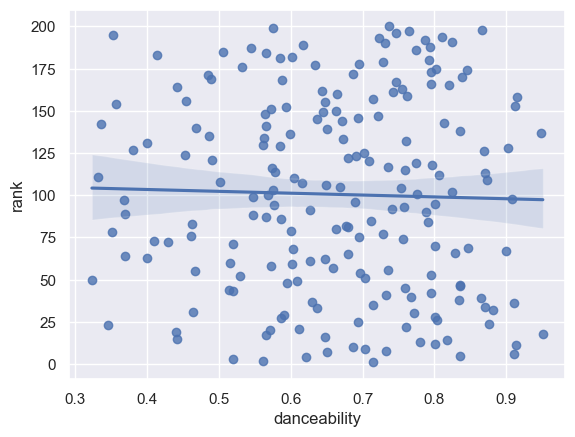

In [25]:
sns.regplot(data=maw,x="danceability", y="rank") 

So, it seems like there is no correlation between danceability and how well a song is performing on the charts, which was a surprise to me. As such, let's look at how songs with a danceability above 0.8 performed.

In [26]:
dart = dar.sort_values(by=["danceability"], ascending=False)

In [27]:
# most danceable tracks
dart.head(20).describe()

variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,20.00000,20.00000
mean,0.891750,179349.100000,0.657400,0.002923,-5.230750,31.000000,66.300000,86.500000,0.100055,1.104727e+07,113.09390,25.20000
std,0.030051,48049.199929,0.113809,0.008469,1.922517,34.449047,53.984501,60.172996,0.071085,5.364381e+06,14.97304,21.40241
min,0.845000,97393.000000,0.498000,0.000000,-8.006000,2.000000,-1.000000,6.000000,0.032400,5.922593e+06,90.02000,1.00000
25%,0.869750,155313.500000,0.573000,0.000000,-6.565250,6.750000,18.750000,33.500000,0.055075,7.221451e+06,100.79525,10.50000
50%,0.890500,173533.500000,0.641500,0.000009,-5.179000,14.500000,55.000000,83.500000,0.077650,8.681357e+06,111.62150,19.50000
75%,0.911250,192850.500000,0.727500,0.000049,-4.198750,42.000000,111.250000,130.250000,0.102250,1.369324e+07,122.76300,28.50000
max,0.951000,290320.000000,0.878000,0.036100,-0.722000,110.000000,157.000000,198.000000,0.288000,2.531674e+07,140.04000,78.00000


In [28]:
# all tracks
dart.tail(180).describe()

variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,1.800000e+02,180.000000,180.000000
mean,0.638106,210965.805556,0.664950,0.018882,-6.060272,46.361111,96.066667,102.055556,0.085178,9.984602e+06,123.333533,45.488889
std,0.134043,43313.961948,0.162855,0.084032,2.525057,47.433313,58.382537,57.581589,0.084997,5.860584e+06,30.166073,55.776138
min,0.323000,111627.000000,0.192000,0.000000,-16.169000,1.000000,-1.000000,1.000000,0.023200,5.889409e+06,67.528000,1.000000
25%,0.563750,178807.000000,0.560750,0.000000,-7.319500,4.750000,47.750000,53.750000,0.036325,6.840774e+06,100.015000,9.000000
50%,0.649500,208032.500000,0.690000,0.000003,-5.519000,27.000000,94.500000,101.500000,0.048150,7.994429e+06,119.027500,23.000000
75%,0.754250,238122.500000,0.780500,0.000096,-4.462250,82.500000,145.250000,151.250000,0.085800,1.040195e+07,142.454500,63.250000
max,0.839000,354520.000000,0.972000,0.631000,-0.514000,181.000000,200.000000,200.000000,0.448000,5.067899e+07,202.466000,297.000000


So, the 20 most danceable tracks in the global charts: 

* are 18 places lower (better) on the charts this week (median)
* have peaked 13 places lower on the charts (median)
* have 12% more streams (mean)
* have spent nearly twice as long in the charts (mean)

than the other 180 tracks in this week's listing

Here, it is clear that these songs are performing significantly better than the average for the global charts; they peak higher, stay in the charts for longer, and achieve more streams.

Let's have a look at the details of the top 20 danceable songs, and see what they look like.

In [29]:
dart.head(20).sort_values(by=["rank"])

,,,variable,danceability,duration_ms,energy,instrumentalness,loudness,peak_rank,previous_rank,rank,speechiness,streams,tempo,weeks_on_chart
uri,track_name,artist_names,region,,,,,,,,,,,,
spotify:track:6Sq7ltF9Qa7SNFBsV5Cogx,Me Porto Bonito,"Bad Bunny, Chencho Corleone",Global,0.911,178567.0,0.712,0.000027,-5.105,2.0,7.0,6.0,0.0817,25316735.0,92.005,23.0
spotify:track:53tfEupEzQRtVFOeZvk7xq,DESPECHÁ,ROSALÍA,Global,0.914,156788.0,0.622,0.000017,-6.538,5.0,12.0,11.0,0.0892,21198542.0,130.040,11.0
spotify:track:2yjlYDiNiQkdxVqTlaSrlX,Super Freaky Girl,Nicki Minaj,Global,0.951,170977.0,0.878,0.000016,-2.565,14.0,15.0,18.0,0.2110,17092565.0,133.014,9.0
spotify:track:31i56LZnwE6uSu3exoHjtB,Neverita,Bad Bunny,Global,0.876,173119.0,0.498,0.000000,-7.511,15.0,20.0,24.0,0.0478,15355691.0,122.016,23.0
spotify:track:5Odq8ohlgIbQKMZivbWkEo,Left and Right (Feat. Jung Kook of BTS),"Charlie Puth, Jung Kook, BTS",Global,0.881,154487.0,0.592,0.000013,-4.898,7.0,31.0,32.0,0.0324,13707294.0,101.058,16.0
spotify:track:7dSZ6zGTQx66c2GF91xCrb,PROVENZA,KAROL G,Global,0.870,210200.0,0.516,0.008230,-8.006,6.0,30.0,34.0,0.0541,13688554.0,111.005,25.0
spotify:track:3LtpKP5abr2qqjunvjlX5i,Doja,Central Cee,Global,0.911,97393.0,0.573,0.000000,-7.430,15.0,33.0,36.0,0.2880,12923318.0,140.040,12.0
spotify:track:2CeKVsFFXG4QzA415QygGb,Feliz Cumpleaños Ferxxo,Feid,Global,0.865,155960.0,0.573,0.000000,-5.501,39.0,43.0,39.0,0.0678,12103268.0,94.999,8.0
spotify:track:27ZZdyTSQWI7Cug2d2PkqV,BILLIE EILISH.,Armani White,Global,0.900,99283.0,0.509,0.000002,-6.647,67.0,73.0,67.0,0.2570,9374257.0,100.007,7.0


So, the best performing track ("Me Porto Bonito" by Bad Bunny & Chencho Corleone) is at number 6 on the charts. A Spanish language club dance track that wouldn't feel out of place at Ibiza, it peaked at the number 2 spot and has been on the scene for nearly 6 months. There is quite a variety of tracks in this club - everything from KPop to Hip Hop, true dance tracks and "folktronica" (whatever that means).

It is also interesting that half (10) of the most danceable tracks are sung in a language other than English (mostly Spanish & Korean). The data used for this project doesn't include language attributes which makes following this further challenging, but it is worth mentioning. 

## What kind of tracks charted in the UK but not globally?
To answer this, we need to find out which tracks charted in the UK but not globally, then investigate what they look like. The method I've found to do this involves creating a fully merged dataframe with an indicator column that tells you whether the row is duplicate or not, then filtering by both this column and region.

In [30]:
all = gbCharts.merge(globalCharts.drop_duplicates(), on=['uri'],
                   how='left', indicator=True)

unique = all[all['_merge'] == 'left_only']

In [31]:
unique.dropna(axis=1)

,rank_x,uri,artist_names_x,track_name_x,source_x,peak_rank_x,previous_rank_x,weeks_on_chart_x,streams_x,duration_ms_x,danceability_x,energy_x,loudness_x,instrumentalness_x,speechiness_x,tempo_x,duration_s_x,change_rank_x,region_x,_merge
11,12,spotify:track:40SBS57su9xLiE1WqkXOVr,LF SYSTEM,Afraid To Feel,Warner Records,1,11,20,1427365,177525.0,0.578,0.912,-3.929,0.003620,0.1140,127.870,177.525,-1,UK,left_only
12,13,spotify:track:1eprzC29mwUQqcVj0eILdx,"Anne-Marie, Aitch",PSYCHO,Atlantic Records UK,13,16,4,1384557,162493.0,0.620,0.681,-4.915,0.000000,0.3560,160.743,162.493,3,UK,left_only
13,14,spotify:track:1LIvdWNdKmHvU0FJvw2diN,"Luude, Mattafix",Big City Life,Warner Records,13,13,15,1301804,146712.0,0.615,0.902,-4.316,0.000039,0.0859,87.030,146.712,-1,UK,left_only
20,21,spotify:track:3PXmiB8Htr95ccAdKyIsyR,"KSI, Tom Grennan",Not Over Yet (feat. Tom Grennan),Atlantic Records UK,10,20,10,1043962,155692.0,0.501,0.775,-2.993,0.000000,0.0520,174.009,155.692,-1,UK,left_only
32,33,spotify:track:5RobAV5ROH5KARimi7n3cO,"venbee, goddard.",messy in heaven,Columbia,33,55,3,857968,170438.0,0.620,0.837,-4.356,0.000242,0.1300,172.081,170.438,22,UK,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,194,spotify:track:5e9TFTbltYBg2xThimr0rU,Fleetwood Mac,The Chain - 2004 Remaster,Rhino/Warner Records,74,-1,152,382189,270213.0,0.545,0.670,-8.810,0.000822,0.0496,151.553,270.213,-195,UK,left_only
194,195,spotify:track:4R2kfaDFhslZEMJqAFNpdd,Taylor Swift,cardigan,Taylor Swift,4,-1,12,380767,239560.0,0.613,0.581,-8.588,0.000345,0.0424,130.033,239.560,-196,UK,left_only
195,196,spotify:track:4CUX44NA1CPEzd0ibMLQsL,"Belters Only, Jazzy",Make Me Feel Good,Polydor Records,8,174,41,380109,197473.0,0.773,0.740,-8.169,0.001830,0.0386,124.014,197.473,-22,UK,left_only
196,197,spotify:track:25FTMokYEbEWHEdss5JLZS,Wheatus,Teenage Dirtbag,Columbia,125,183,10,380010,241667.0,0.625,0.850,-3.904,0.000233,0.0495,94.661,241.667,-14,UK,left_only


Nearly half of the tracks on the UK charts aren't charting globally, which is more than I expected. Let's look at the summaries for these tracks.

In [32]:
# UK-only tracks 
unique.dropna(axis=1).describe()

,rank_x,peak_rank_x,previous_rank_x,weeks_on_chart_x,streams_x,duration_ms_x,danceability_x,energy_x,loudness_x,instrumentalness_x,speechiness_x,tempo_x,duration_s_x,change_rank_x
count,95.000000,95.000000,95.000000,95.000000,9.500000e+01,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,120.442105,49.084211,100.305263,51.863158,5.236035e+05,212239.147368,0.638547,0.686095,-6.402505,0.024288,0.119654,123.934263,212.239147,-20.136842
std,51.429712,45.444065,58.022203,66.712883,1.983715e+05,57627.627253,0.166384,0.179570,2.462701,0.119459,0.106864,25.981979,57.627627,50.230026
min,12.000000,1.000000,-1.000000,1.000000,3.772620e+05,83200.000000,0.228000,0.236000,-15.159000,0.000000,0.027600,75.089000,83.200000,-196.000000
25%,84.500000,9.500000,53.500000,9.000000,4.136450e+05,175782.500000,0.538500,0.564500,-7.576000,0.000000,0.040000,103.509500,175.782500,-19.000000
50%,124.000000,33.000000,105.000000,22.000000,4.576510e+05,202133.000000,0.667000,0.715000,-5.969000,0.000001,0.059200,123.061000,202.133000,-5.000000
75%,164.500000,79.500000,148.500000,55.500000,5.514330e+05,236240.000000,0.754000,0.834500,-4.520000,0.000275,0.183000,142.528000,236.240000,4.000000
max,200.000000,181.000000,196.000000,298.000000,1.427365e+06,440983.000000,0.975000,0.962000,-2.650000,0.826000,0.366000,180.345000,440.983000,61.000000


In [33]:
# all UK tracks  
gbCharts.describe()

,rank,peak_rank,previous_rank,weeks_on_chart,streams,duration_ms,danceability,energy,loudness,instrumentalness,speechiness,tempo,duration_s,change_rank
count,200.000000,200.000000,200.000000,200.000000,2.000000e+02,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,44.385000,89.540000,49.310000,6.529179e+05,213197.910000,0.626670,0.664345,-6.467765,0.023954,0.095755,124.021150,213.197910,-10.960000
std,57.879185,43.893736,59.521192,62.426269,4.178586e+05,53382.042443,0.160168,0.177382,2.554862,0.109045,0.091577,27.774396,53.382042,41.080977
min,1.000000,1.000000,-1.000000,1.000000,3.772620e+05,83200.000000,0.228000,0.192000,-16.169000,0.000000,0.025600,67.528000,83.200000,-196.000000
25%,50.750000,6.000000,37.750000,9.000000,4.238465e+05,176488.750000,0.518000,0.542500,-7.606750,0.000000,0.038175,102.501000,176.488750,-8.250000
50%,100.500000,27.500000,88.500000,21.000000,5.047320e+05,206741.500000,0.633500,0.689000,-5.976000,0.000005,0.053000,123.042000,206.741500,-1.000000
75%,150.250000,73.000000,139.250000,66.000000,6.657060e+05,240786.500000,0.739250,0.806250,-4.581500,0.000274,0.106000,142.264500,240.786500,5.000000
max,200.000000,181.000000,200.000000,303.000000,3.472327e+06,440983.000000,0.975000,0.965000,-1.248000,0.826000,0.366000,202.466000,440.983000,78.000000


## Conclusions
Using the Spotify Charts and API, we've been able to identify "Forget Me" by Lewis Capaldi as the "most average" track on the Global Charts. It's a track that errs on the short side, has pretty much no instrumentalness and mediocre chart performance (peaking at 57th place), and feels like a crossover between an acoustic guitar track and Britpop. My personal review of the track is also "solidly mediocre", so I guess this conclusion has accidentally met my song taste. 

Looking into danceability proved rather interesting - there isn't really any correlation between it and any of the performance characteristics when looking at the whole chart, but the most danceable songs performed significantly better than average. Lots of these tracks are also not primarily sung in English, which was a surprise to me. I think that looking into how non-English charts perform globally, and particularly how the global charts are weighted by region. Spotify are quite close-lipped about exactly how their charts work, likely because it is intrinsically linked to how they recommend tracks to users. The charts for non-English markets would be especially interesting to look into as part of a follow-up project, as well as how they influence the global charts.

My orignal plan for this coursework was to use my own Spotify history to look at my tastes in music, although unfortunately time constraints meant that I couldn't really find the convincing narrative that would make it pop. Since first working with Spotify data as part of a hobby project a few years ago, I've been especially interested in whether I can predict whether I would skip a particular track based on mood/time/location - essentially, a simplified version of Spotify's recommendation algorithms. Should I have the opportunity, this is where I would take a similar project, using the skills from DataSci. The wealth of data that Spotify collects both about users and the tracks themselves gives plenty of options for future analysis, for better and worse.